In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/metal_nut')
!pwd

/content/gdrive/My Drive/Colab Notebooks/metal_nut


In [0]:
import os
import json

import cv2
import random
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
ROWS = 256
COLS = 256
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS,COLS,CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [0]:
import glob
train_images = glob.glob('./train/good/*')
test_ng_images = glob.glob('./test/*[!good !flip]/*')
mask_images = glob.glob('./ground_truth/*[!flip]/*')


train_images = sorted(train_images)
test_ng_images = sorted(test_ng_images)
mask_images = sorted(mask_images)

images = train_images[:70] + test_ng_images

In [0]:
def img_msk(img_path,msk_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  msk = cv2.imread(msk_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
  msk = cv2.resize(msk, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
  plt.subplot(1,2,1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.subplot(1,2,2)
  plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))

  plt.show()

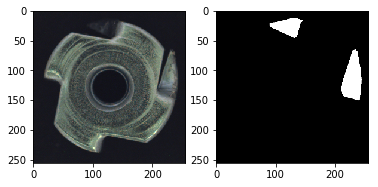

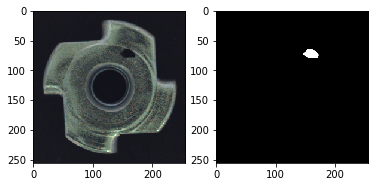

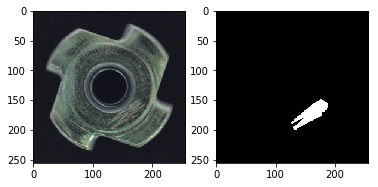

In [0]:
#異常の例(bent,color,scratch)
img_msk('./test/bent/000.png','./ground_truth/bent/000_mask.png')
img_msk('./test/color/000.png','./ground_truth/color/000_mask.png')
img_msk('./test/scratch/000.png','./ground_truth/scratch/000_mask.png')

In [0]:
print(len(train_images),len(test_ng_images),len(mask_images),len(images))

220 70 70 140


In [0]:
#imageでDataframe作成
df = pd.DataFrame(images,columns=['ImageId'])
df.tail()

,ImageId
135,./test/scratch/018.png
136,./test/scratch/019.png
137,./test/scratch/020.png
138,./test/scratch/021.png
139,./test/scratch/022.png


In [0]:
#DaraFrameにmaskの列追加
maskId = []
for i in range(len(images)):
  if i < len(mask_images):
    maskId.append(0)
  else:
    maskId.append(mask_images[i-len(mask_images)])
df['maskId'] = pd.DataFrame(maskId)
df.tail()

,ImageId,maskId
135,./test/scratch/018.png,./ground_truth/scratch/018_mask.png
136,./test/scratch/019.png,./ground_truth/scratch/019_mask.png
137,./test/scratch/020.png,./ground_truth/scratch/020_mask.png
138,./test/scratch/021.png,./ground_truth/scratch/021_mask.png
139,./test/scratch/022.png,./ground_truth/scratch/022_mask.png


In [0]:
#dataframeをシャッフル
df = df.sample(frac=1).reset_index(drop=True)
df.tail(10)

,ImageId,maskId
130,./train/good/023.png,0
131,./train/good/018.png,0
132,./test/scratch/010.png,./ground_truth/scratch/010_mask.png
133,./train/good/017.png,0
134,./train/good/029.png,0
135,./train/good/033.png,0
136,./test/scratch/014.png,./ground_truth/scratch/014_mask.png
137,./test/scratch/016.png,./ground_truth/scratch/016_mask.png
138,./test/bent/000.png,./ground_truth/bent/000_mask.png
139,./test/color/017.png,./ground_truth/color/017_mask.png


In [0]:
#maskの設定
mask = []
for i,Id in enumerate(df['maskId']):
  if Id == 0:
    mask.append(np.zeros(shape=(256,256),dtype='int')) #異常なしの時は真っ黒の画像
  else:
    img = cv2.imread(df['maskId'][i],cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    mask.append(img)
mask = np.reshape(mask,(len(mask),256,256,1)) #list型のmaskをnp配列に変換
mask[mask!=0] = 255                           #mask画像の二値化、真っ黒以外は白にする
mask = mask.astype('float32')/255.            #[0～1]にする

In [0]:
train = prep_data(df['ImageId'])

train = train.astype('float32')/255.          #[0～1]にする

Processed 0 of 140


In [0]:
df.head()

,ImageId,maskId
0,./test/bent/004.png,./ground_truth/bent/004_mask.png
1,./train/good/061.png,0
2,./test/color/020.png,./ground_truth/color/020_mask.png
3,./train/good/049.png,0
4,./test/scratch/019.png,./ground_truth/scratch/019_mask.png


In [0]:
#testsize指定
X_train, X_test, Y_train, Y_test = train_test_split(train, mask,test_size=0.2,shuffle=False)

In [0]:
df.head(6)

,ImageId,maskId
0,./train/good/017.png,0
1,./train/good/026.png,0
2,./test/bent/024.png,./ground_truth/bent/024_mask.png
3,./train/good/005.png,0
4,./train/good/038.png,0
5,./test/color/013.png,./ground_truth/color/013_mask.png


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

In [0]:
model = build_model((256, 256, 3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 8)  584         conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [0]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=300)

Epoch 1/300
112/112 [==============================] - 3s 30ms/step - loss: 1.7044 - dice_coef: 0.0316
Epoch 2/300
112/112 [==============================] - 1s 11ms/step - loss: 1.4408 - dice_coef: 0.0287
Epoch 3/300
112/112 [==============================] - 1s 11ms/step - loss: 1.1918 - dice_coef: 0.0046
Epoch 4/300
112/112 [==============================] - 1s 11ms/step - loss: 1.1013 - dice_coef: 0.0117
Epoch 5/300
112/112 [==============================] - 1s 11ms/step - loss: 1.0857 - dice_coef: 0.0156
Epoch 6/300
112/112 [==============================] - 1s 11ms/step - loss: 1.0787 - dice_coef: 0.0136
Epoch 7/300
112/112 [==============================] - 1s 11ms/step - loss: 1.0772 - dice_coef: 0.0121
Epoch 8/300
112/112 [==============================] - 1s 11ms/step - loss: 1.0757 - dice_coef: 0.0132
Epoch 9/300
112/112 [==============================] - 1s 11ms/step - loss: 1.0730 - dice_coef: 0.0152
Epoch 10/300
112/112 [==============================] - 1s 11ms/step - lo

KeyboardInterrupt: ignored

In [0]:
def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['dice_coef'],label="acc for training")
    plt.plot(hist.history['loss'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

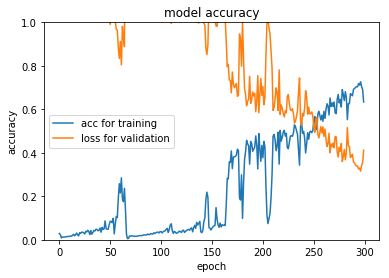

In [0]:
plot_history_acc(hist)

In [0]:
pred = model.predict(X_test)

In [0]:
pred[pred<0.5] = 0
pred[pred>=0.5] = 1.

<function matplotlib.pyplot.show>

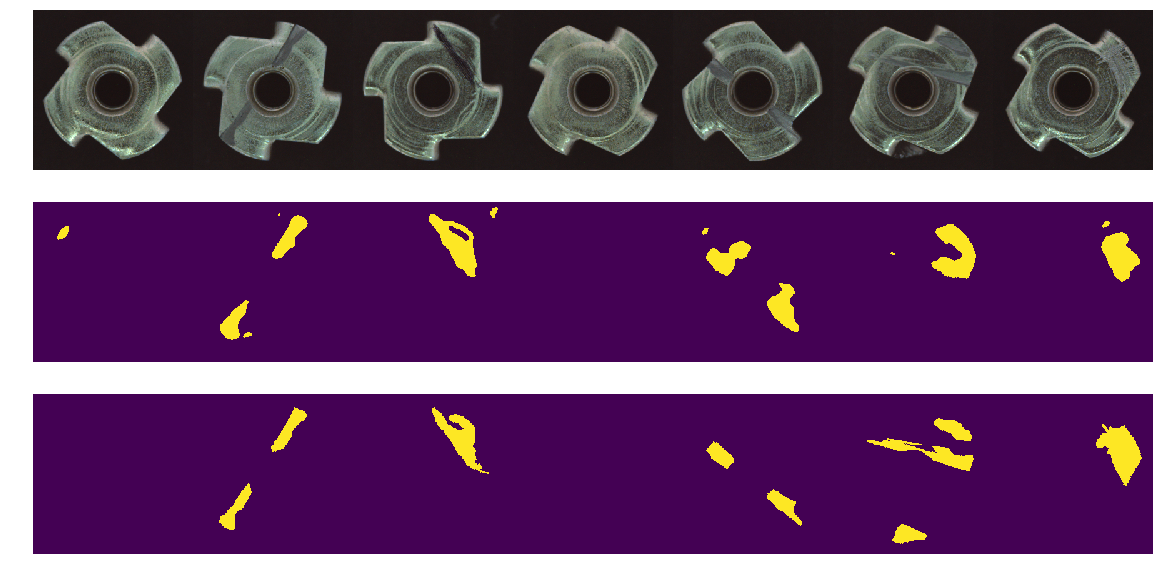

In [0]:
i=7
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)
X_pair = np.concatenate((X_test[0+i],X_test[1+i],X_test[2+i],X_test[3+i],X_test[4+i],X_test[5+i],X_test[6+i]),axis=1)
plt.imshow(X_pair)
plt.axis('off')
plt.subplot(3,1,2)
pred_pair = np.concatenate((pred[0+i],pred[1+i],pred[2+i],pred[3+i],pred[4+i],pred[5+i],pred[6+i]),axis=1)
plt.imshow(pred_pair.reshape(256,256*7))
plt.axis('off')
plt.subplot(3,1,3)
Y_pair = np.concatenate((Y_test[0+i],Y_test[1+i],Y_test[2+i],Y_test[3+i],Y_test[4+i],Y_test[5+i],Y_test[6+i]),axis=1)
plt.imshow(Y_pair.reshape(256,256*7))
plt.axis('off')
plt.show

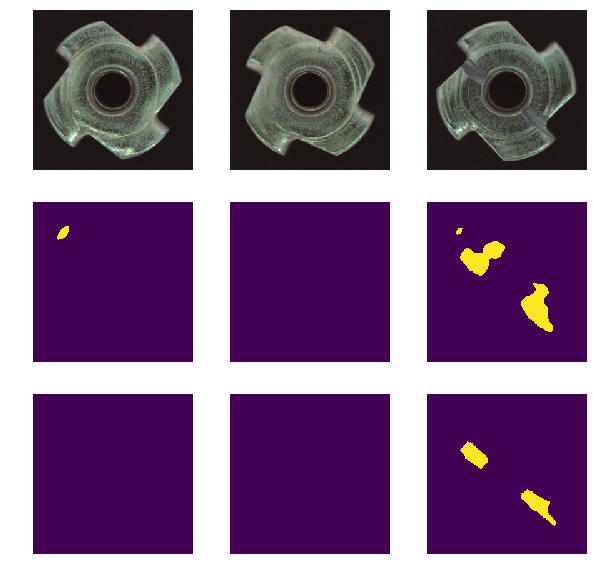

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.axis('off')
plt.imshow(X_test[7])
plt.subplot(3,3,2)
plt.axis('off')
plt.imshow(X_test[10])
plt.subplot(3,3,3)
plt.axis('off')
plt.imshow(X_test[11])
plt.subplot(3,3,4)
plt.axis('off')
plt.imshow(pred[7].reshape(256,256))
plt.subplot(3,3,5)
plt.axis('off')
plt.imshow(pred[10].reshape(256,256))
plt.subplot(3,3,6)
plt.axis('off')
plt.imshow(pred[11].reshape(256,256))
plt.subplot(3,3,7)
plt.axis('off')
plt.imshow(Y_test[7].reshape(256,256))
plt.subplot(3,3,8)
plt.axis('off')
plt.imshow(Y_test[10].reshape(256,256))
plt.subplot(3,3,9)
plt.axis('off')
plt.imshow(Y_test[11].reshape(256,256))


<function matplotlib.pyplot.show>

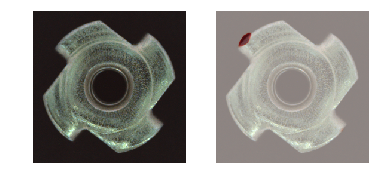

In [0]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(X_test[7])
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(X_test[7])
plt.imshow(pred[7].reshape(256,256),alpha=0.5,cmap="Reds")
plt.show

In [0]:
count_mask = []
for i in range(len(pred)):
  count_mask.append(np.count_nonzero(pred[i]))

In [0]:
len(X_test)

28

(array([12.,  1.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.  ,  141.14,  282.28,  423.42,  564.56,  705.7 ,  846.84,
         987.98, 1129.12, 1270.26, 1411.4 , 1552.54, 1693.68, 1834.82,
        1975.96, 2117.1 , 2258.24, 2399.38, 2540.52, 2681.66, 2822.8 ,
        2963.94, 3105.08, 3246.22, 3387.36, 3528.5 , 3669.64, 3810.78,
        3951.92, 4093.06, 4234.2 , 4375.34, 4516.48, 4657.62, 4798.76,
        4939.9 , 5081.04, 5222.18, 5363.32, 5504.46, 5645.6 , 5786.74,
        5927.88, 6069.02, 6210.16, 6351.3 , 6492.44, 6633.58, 6774.72,
        6915.86, 7057.  ]),
 <a list of 50 Patch objects>)

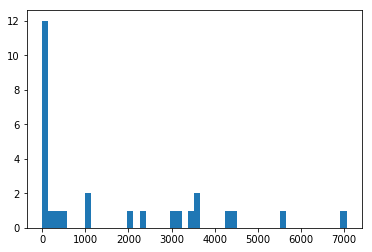

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(count_mask, bins=50)